In [1]:
import yaml
import torch
import argparse
import timeit
import numpy as np

from torch.utils import data


from ptsemseg.models import get_model
from ptsemseg.loader import get_loader
from ptsemseg.metrics import runningScore
from ptsemseg.utils import convert_state_dict

torch.backends.cudnn.benchmark = True
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import scipy.misc as misc

In [2]:
with open('configs/fcn8s_cityscapes.yml') as f:
    cfg = yaml.load(f)

# Setup Dataloader
data_loader = get_loader(cfg["data"]["dataset"])
data_path = cfg["data"]["path"]

loader = data_loader(
    data_path,
    split=cfg["data"]["val_split"],
    is_transform=True,
    img_size=(cfg["data"]["img_rows"], cfg["data"]["img_cols"]),
)

n_classes = loader.n_classes

valloader = data.DataLoader(loader, batch_size=cfg["training"]["batch_size"], num_workers=8)
running_metrics = runningScore(n_classes)

# Setup Model
model_path = 'runs/fcn8s_cityscapes/20201210_16475/fcn8s_cityscapes_best_model.pkl'
model = get_model(cfg["model"], n_classes)
state = convert_state_dict(torch.load(model_path)["model_state"])
model.load_state_dict(state)


Found 500 val images


<All keys matched successfully>

torch.Size([2, 3, 256, 512])
WARN: resizing labels yielded fewer classes
torch.Size([2, 19, 256, 512])
(2, 256, 512)
torch.Size([2, 3, 256, 512])
torch.Size([2, 19, 256, 512])
(2, 256, 512)


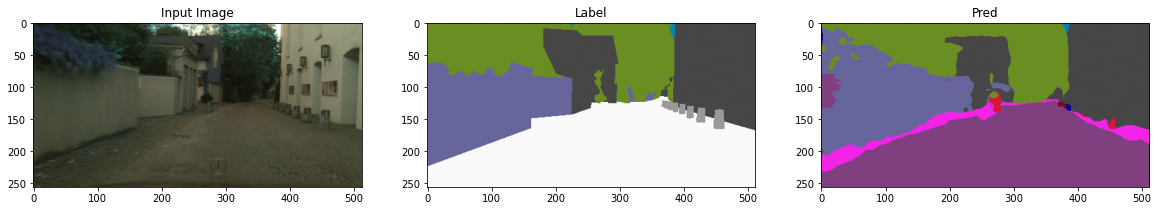

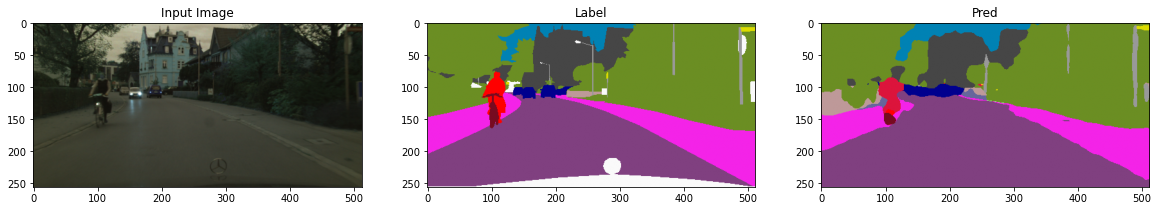

In [22]:
val = iter(valloader)
val.next()
for i in range(2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))
    im, lbl = val.next()
    im_plt = np.transpose(im, [0, 2, 3, 1])

    ax1.imshow(im_plt[i])
    ax1.set_title('Input Image')
    ax2.imshow(loader.decode_segmap(lbl.numpy()[i]))
    ax2.set_title('Label')

    outputs = model(im)
    pred = outputs.data.max(1)[1].cpu().numpy()
    decoded = loader.decode_segmap(pred[i])
    
    ax3.imshow(decoded)
    ax3.set_title('Pred')

(480, 640, 3)
torch.Size([2, 3, 480, 640])
torch.Size([2, 19, 480, 640])
(2, 480, 640)


Text(0.5, 1.0, 'Pred')

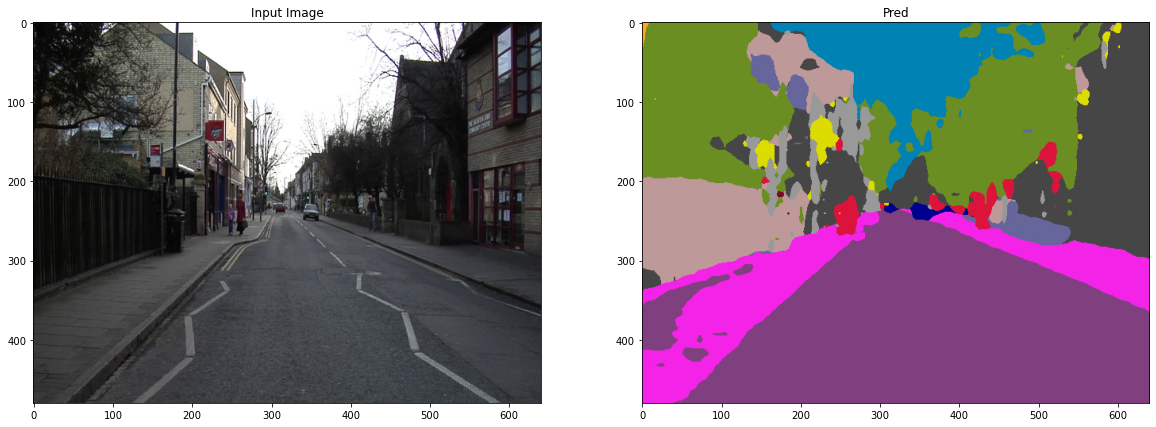

In [28]:
test_image = plt.imread('street_test_image.png')
print(test_image.shape)
test_image_reshape = np.transpose(test_image, [2, 0, 1])

test_image_vec = torch.zeros((2, int(test_image_reshape.shape[0]), int(test_image_reshape.shape[1]), int(test_image_reshape.shape[2])))
test_image_vec[0] = torch.from_numpy(test_image_reshape)
test_image_vec[1] = torch.from_numpy(test_image_reshape)
print(test_image_vec.shape)
outputs = model(test_image_vec)
print(outputs.shape)
pred = outputs.data.max(1)[1].cpu().numpy()
print(pred.shape)
decoded = loader.decode_segmap(pred[1])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(test_image)
ax1.set_title('Input Image')
ax2.imshow(decoded)
ax2.set_title('Pred')

In [14]:
test_image_reshape.shape[0]

3